# TITANIC SURVIVAL PREDICTION


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading the data set

In [10]:
data = pd.read_csv('tested.csv')

## Data Preprocessing


In [11]:
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

data['FamilySize'] = data['SibSp'] + data['Parch']
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Dona'], 'Royalty')
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace(['Mme'], 'Mrs')

data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'Title'], drop_first=True)


## Split the data into training and testing sets

In [12]:
X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Feature Scaling

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature Selection

In [14]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

## Initialize and train the models with hyperparameter tuning

In [15]:
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_search_rf.fit(X_train_selected, y_train)
best_rf_model = grid_search_rf.best_estimator_

grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gb, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_search_gb.fit(X_train_selected, y_train)
best_gb_model = grid_search_gb.best_estimator_

## Voting Classifier Ensemble

In [16]:
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', best_rf_model),
    ('gradient_boosting', best_gb_model)
], voting='soft')

voting_classifier.fit(X_train_selected, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         random_state=42))],
                 voting='soft')

## Cross-validation

In [17]:
cv_scores = cross_val_score(voting_classifier, X_train_selected, y_train, cv=StratifiedKFold(n_splits=5))
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


## Make predictions

In [18]:
y_pred = voting_classifier.predict(X_test_selected)

## Evaluate the model

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Confusion Matrix:
 [[53  0]
 [ 0 31]]


In [20]:
## Feature Importances (from the best Random Forest model)

In [21]:
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns

## Correlation Matrix Heatmap

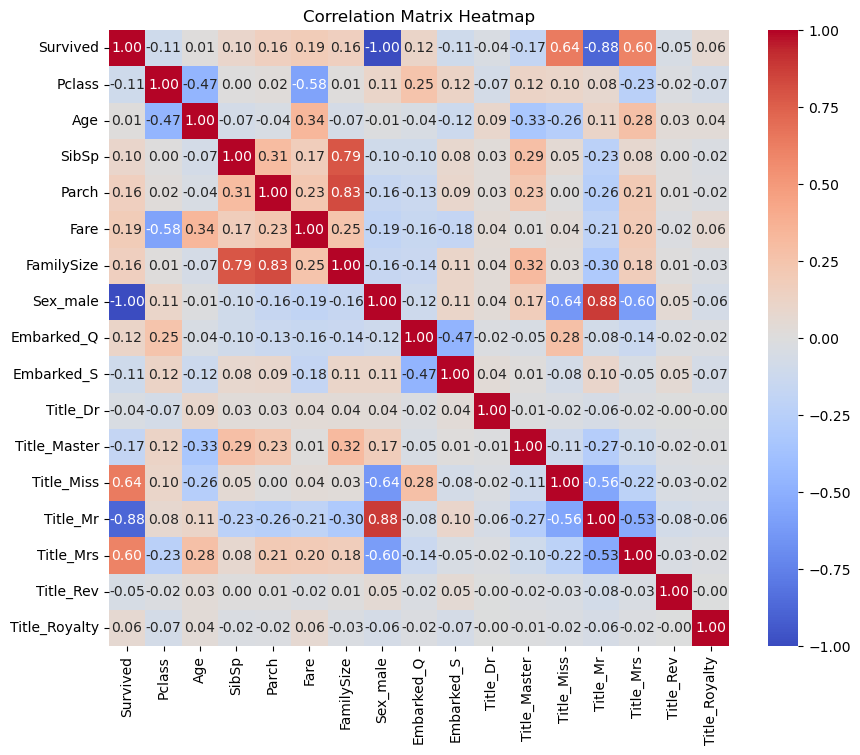

In [22]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

## Age Distribution by Survival

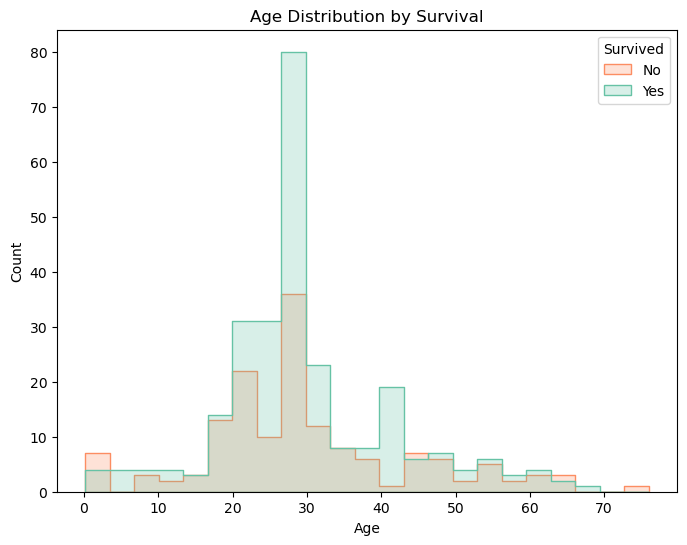

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Age', hue='Survived', element='step', common_norm=False, palette='Set2')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

## Survival Rate by Family Size

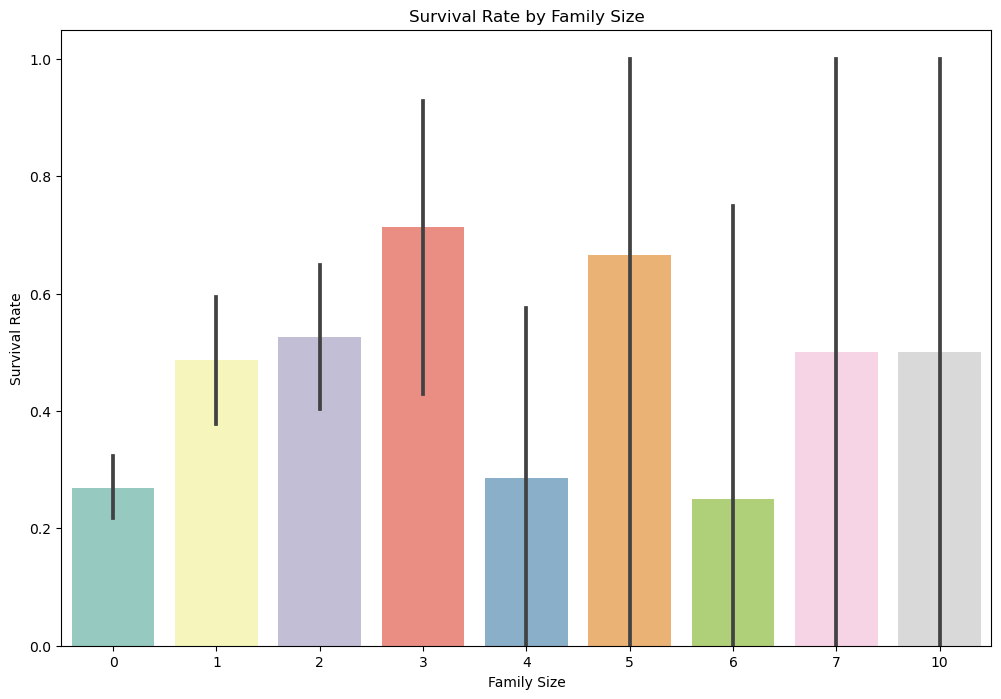

In [24]:
plt.figure(figsize=(12, 8))
sns.barplot(x='FamilySize', y='Survived', data=data, palette='Set3')
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.show()

## Fare Distribution by Class and Survival

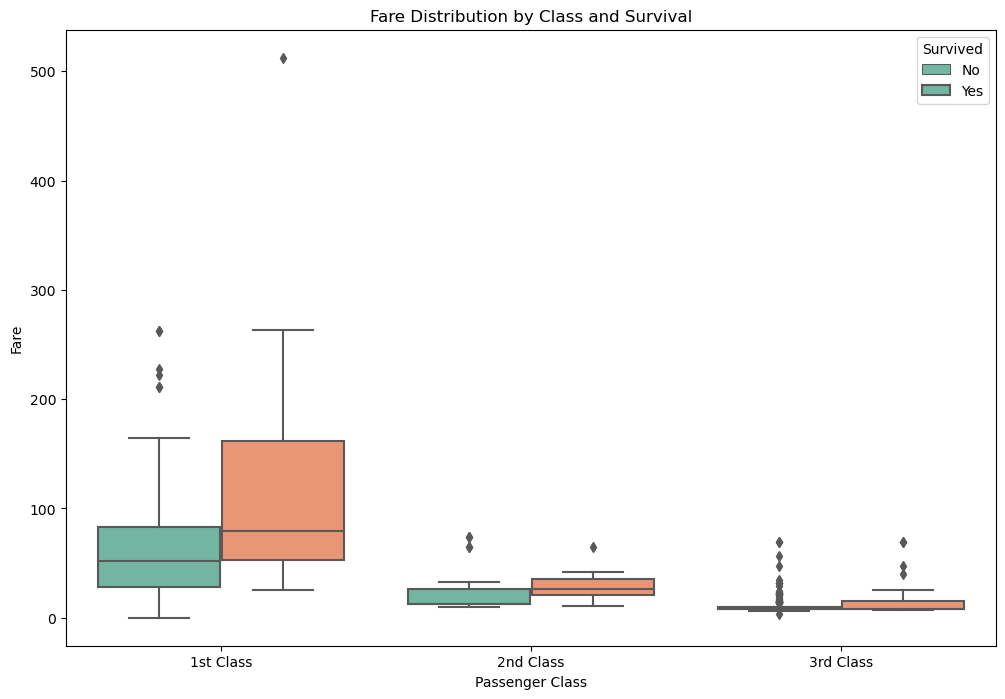

In [25]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=data, palette='Set2')
plt.title('Fare Distribution by Class and Survival')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.xticks([0, 1, 2], ['1st Class', '2nd Class', '3rd Class'])
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

## Pair Plot of Features

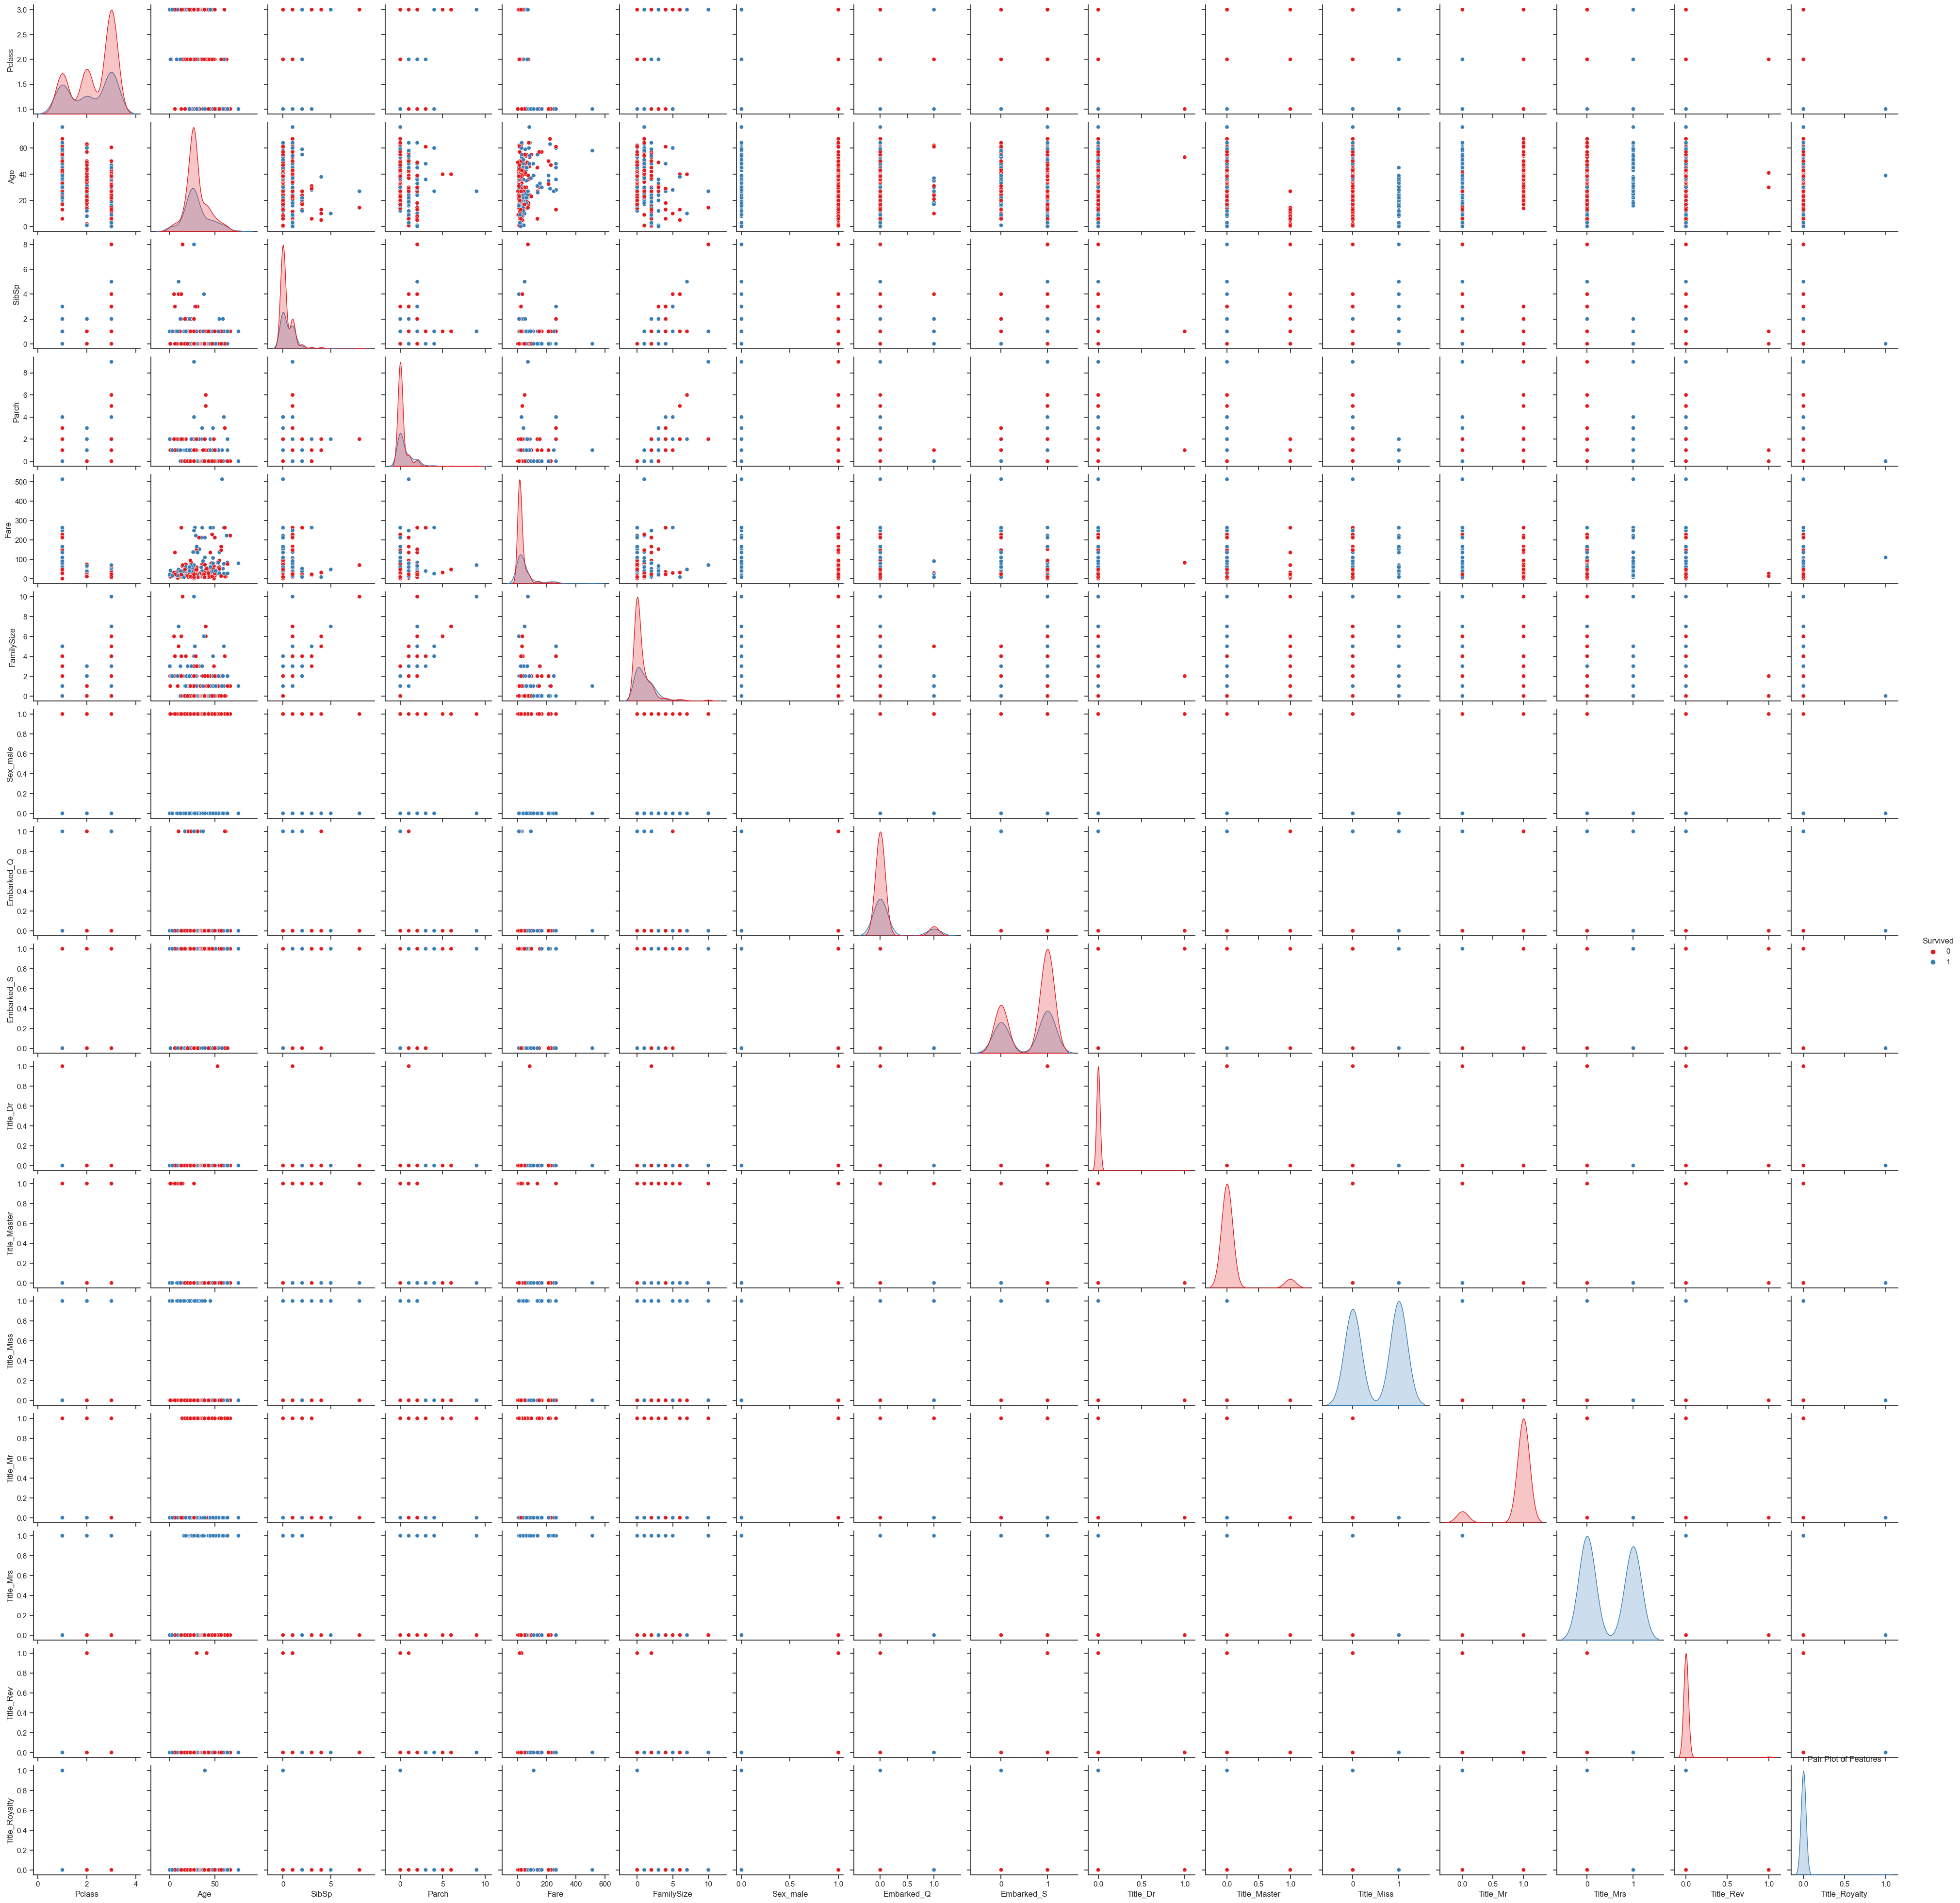

In [26]:
sns.set(style="ticks")
sns.pairplot(data=data, hue='Survived', palette='Set1')
plt.title('Pair Plot of Features')
plt.show()
